Problem 2 : Implements a method with unsupervised selection of the centers. Select the centers randomly on the P
points of the training set or my a cluster algorithm. Choose the weights by minimizing the convex quadratic function.

In this problem we are going to solve the RBF network training by choosing apriori the center with a clustering algorithm and then solve the convex quadratic problem respect to the weights.

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy.optimize import minimize
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time

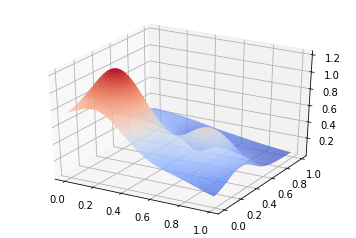

In [2]:
franke_function = lambda x1,x2 : 0.75*np.exp(((-(9*x1 - 2)**2)/4) - ((9*x2 - 2)**2)/4) \
+ 0.75*np.exp(((-(9*x1 + 1)**2)/49) - (9*x2 + 1)/10) + 0.5*np.exp(((-(9*x1 - 7)**2)/4) \
- ((9*x2 - 3)**2)/4) - 0.2*np.exp(((-(9*x1 - 4)**2) - (9*x2 - 7)**2))
X = np.arange(0, 1, 0.01) 
Y = np.arange(0, 1, 0.01)
X,Y = np.meshgrid(X, Y)  
f = franke_function(X,Y) 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, f, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0)
plt.show() 

In [3]:
def plot_(estimated_y):
    X1 = np.arange(0, 1, 0.01)
    X2 = np.arange(0, 1, 0.01)
    X1,X2 = np.meshgrid(X1,X2)   
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X1,X2,estimated_y , rstride=1, cstride=1,cmap=cm.coolwarm,
                    linewidth=0.01)
    plt.show() 
    return '.'

In [4]:
franke_function = lambda x1,x2 : 0.75*np.exp(((-(9*x1 - 2)**2)/4) - ((9*x2 - 2)**2)/4) \
+ 0.75*np.exp(((-(9*x1 + 1)**2)/49) - (9*x2 + 1)/10) + 0.5*np.exp(((-(9*x1 - 7)**2)/4) \
- ((9*x2 - 3)**2)/4) - 0.2*np.exp(((-(9*x1 - 4)**2) - (9*x2 - 7)**2))

x1 = np.random.uniform(0, 1, 100) 
x2 = np.random.uniform(0, 1, 100)
noise = np.random.uniform(0, 0.1, len(x1)) 
y = franke_function(x1,x2) + noise
x1_train = x1[0:80]
x2_train = x2[0:80]
y_train = y[0:80]

x1_test = x1[80:100]
x2_test = x2[80:100]
y_test = y[80:100]

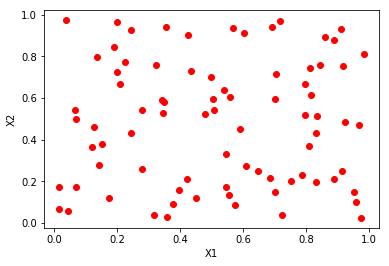

In [5]:
plt.plot(x1_train,x2_train, 'ro')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In K-Means the choice of the number of clusters K is very important. There are many statistical methods that can help
to solve ths problem. Among others, a simple method is to plot the average of the sum of the square of the distance for every K and choose the number of clusters for which the curve starts flattening out (Elbow point).

In [6]:
X = np.matrix([x1_train,x2_train])
X = np.transpose(X)
K = range(1,10)
KM = [kmeans(X,k) for k in K]
euclidean_centroid = [cdist(X, centroid, 'euclidean') for(centroid,var) in KM]
dist = [np.min(D,axis=1) for D in euclidean_centroid]
avgWithinSS = [sum(d)/len(X) for d in dist]
centers = KM[3][0]

Now we'll plot the result and we can see how to choose K.

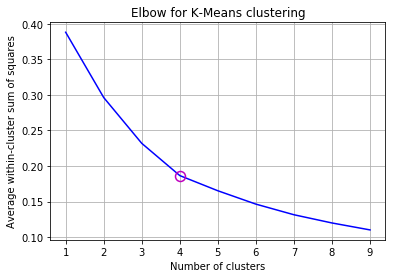

In [7]:
kIdx = 3
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10,
markeredgewidth=1.5, markeredgecolor='m', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

Now we compute the optimization procedure to the quadratic convex function respect to the weights using the BFGS.

In [24]:
mu = [0.0, 0.001, 0.01, 0.1, 1, 2, 5]
mse_train = []
mse_test = []

In [25]:
function_1 = lambda w,c,x1,x2,y,mu: 0.5*(np.sum(((w[0]*(np.exp(-((x1 - c[0][0])**2 + (x2 - c[0][1]))**2)) + w[1]*(np.exp
(-((x1 - c[1][0])**2 + (x2 - c[1][1])**2))) + w[2]*(np.exp(-((x1 - c[2][0])**2 + (x2 - c[2][1])**2))) + w[3]*(np.exp
(-((x1 - c[3][0])**2 + (x2 - c[3][1])**2)))) - y)**2)) + mu*np.linalg.norm(w)

mse = lambda w,c,x1,x2,y: np.sum(((w[0]*(np.exp(-(x1 - c[0][0])**2 + (x2 - c[0][1])**2)) + w[1]*(np.exp
(-((x1 - c[1][0])**2 + (x2 - c[1][1])**2))) + w[2]*(np.exp(-((x1 - c[2][0])**2 + (x2 - c[2][1])**2))) + w[3]*(np.exp
(-((x1 - c[3][0])**2 + (x2 - c[3][1])**2)))) - y)**2) / len(x1)

for reg in mu:
    start = timer()
    opt_result = minimize(function_1, x0=(0,0,0,0), args=(centers, x1_train, x2_train, y_train, reg))
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    mse_test.append(mse(opt_result.x, centers, x1_test,x2_test,y_test))
    mse_train.append(mse(opt_result.x, centers, x1_train,x2_train,y_train))
    print("test error = "+str(mse(opt_result.x, centers, x1_test,x2_test,y_test)))
    print("training error = "+str(mse(opt_result.x, centers, x1_train,x2_train,y_train)))


Regularizer = 0.0
Objective function value = 0.6502572733414816 Time = 0.007407902001432376
test error = 0.1566734790334433
training error = 0.11646624882288137

Regularizer = 0.001
Objective function value = 0.6529261193976337 Time = 0.0068958390002080705
test error = 0.15001298138459435
training error = 0.11170171667264477

Regularizer = 0.01
Objective function value = 0.6753102133510407 Time = 0.007152925998525461
test error = 0.09875983888641549
training error = 0.0750928586335425

Regularizer = 0.1
Objective function value = 0.80702545095151 Time = 0.007129942998290062
test error = 0.021216883442419794
training error = 0.021150404196724804

Regularizer = 1
Objective function value = 1.619120887174879 Time = 0.005839661000209162
test error = 0.05520513936449907
training error = 0.047298671634423806

Regularizer = 2
Objective function value = 2.334331152848364 Time = 0.006630288000451401
test error = 0.06709309121586648
training error = 0.057753454496429366

Regularizer = 5
Objecti

\vspace{5mm}

For evaluate the test and training error we can plot all the errors:
\vspace{5mm}

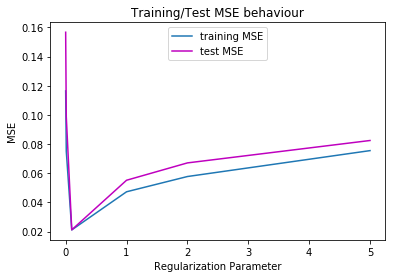

In [26]:
plt.plot(mu,mse_train,label='training MSE')
plt.plot(mu,mse_test,color='m', label='test MSE')
plt.xlabel('Regularization Parameter')
plt.ylabel('MSE')
plt.title('Training/Test MSE behaviour')
plt.legend(loc = 'upper center')
plt.show()

Setting approprately the regularization parameter we can improve the generalization property of the model.